In [1]:
# import necessary modules
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft, ifft , rfft, irfft , fftfreq
from numpy import exp, log, log10, cos, sin, pi, cosh, sinh , sqrt
from classy import Class
from scipy.optimize import fsolve
from scipy.special import gamma
from scipy.special import hyp2f1
from scipy import interpolate
import sys,os
from time import time
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy import special
from scipy.special import factorial
import json
import math

import classy
print(classy.__version__)
print(classy.__file__)
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('text', usetex=True)
plt.rcParams["text.usetex"] = True

v3.2.5
/Users/florian/.local/lib/python3.8/site-packages/classy-3.2.5-py3.8-macosx-10.9-x86_64.egg/classy.cpython-38-darwin.so


In [54]:
def read_in_bf(path, nb_params):
    # Load data as strings
    data = np.loadtxt(path, dtype=str, skiprows=0)
    
    # Initialize the dictionary string
    string = '{'
    for i in range(nb_params):
        # Remove commas from the key and value
        key_without_commas = data[0, i].replace(',', '')
        value_without_commas = data[1, i].replace(',', '')
        
        # Construct the temporary string
        tmp_str = '"' + key_without_commas + '": ' + value_without_commas
        print(tmp_str)
        
        # Append the temporary string to the main string
        string = string + tmp_str
        if (i < nb_params - 1):
            string = string + ','
    string = string + '}'
    
    # Replace specific substrings if necessary
    string = string.replace("logA", "ln10^{10}A_s")
    
    # Convert the string to a dictionary
    dict_res = json.loads(string)
    print ("BF DATA:", dict_res)
    return dict_res


############################################

fhnede_value=0.05
deltaneff = 7.4*fhnede_value/(1.-fhnede_value) ### assumes some su(n)


dict_general_ETHOS={
        'alpha_idm_dr': .75,
        'beta_idr': .75,
        'stat_f_idr': 1,
        'k_output_values':'0.00001,0.001,0.01,0.1,0.5,5',
        'start_small_k_at_tau_c_over_tau_h':0.000001,
        'start_large_k_at_tau_h_over_tau_k':0.000001,
        'output':'tCl,pCl,lCl,mPk',
       'lensing':'yes',
        'background_verbose':'4',
        'perturbations_verbose':'2',
        'thermodynamics_verbose':'2',
        'P_k_max_1/Mpc':30.0,'z_max_pk': 4.,'l_switch_limber':9,
        'idr_nature':'fluid'
    }


dict_general_DRMD={
        'YHe': 0.2456,
        'k_output_values':'0.00001,0.001,0.01,0.1,0.5,5',
        'z_stop': 0000,
        'f_idm_drmd': 0.02,
        'delta_Neff_drmd': deltaneff,
        'G_over_aH_drmd_ini': 40000,
        'idm_drmd_tight_coupling_trigger_G_over_aH': 300,
        'output':'tCl,pCl,lCl,mPk',
        'lensing':'yes',
        'background_verbose':'3',
        'perturbations_verbose':'0',
        'thermodynamics_verbose':'2',
        'P_k_max_1/Mpc':30.0,'z_max_pk': .1,'l_switch_limber':9,
       # 'non linear': 'hmcode'
    }



dict_general_LCDM={
        'YHe': 0.2456,
        'k_output_values':'0.00001,0.001,0.01,0.1,0.5,5',
        'output':'tCl,pCl,lCl,mPk',
        'lensing':'yes',
        'background_verbose':'0',
        'perturbations_verbose':'0',
        'thermodynamics_verbose':'0',
        'P_k_max_1/Mpc':30.0,'z_max_pk': 4.,'l_switch_limber':9,
        #'non linear': 'hmcode',
    }


In [55]:
BF_FOLDER = "."

#bfdata = read_in_bf(BF_FOLDER+"/HNEDE_base_H0_1.bestfit",7)
dict_HNEDE_base_H0 = dict_general_DRMD
#dict_HNEDE_base_H0.update(bfdata)
NEDE_base_H0= Class()
NEDE_base_H0.set(dict_HNEDE_base_H0)
NEDE_base_H0.compute()
NEDE_base_H0_bg = NEDE_base_H0.get_background()
NEDE_base_H0_pert = NEDE_base_H0.get_perturbations()



Running CLASS version v3.2.5
Computing background
 -> dark radiation Delta Neff (DRMD) 3.894737e-01
 -> dark radiation matter decoupling (DRMD) with initial Gamma0 = 72.905915 1/Mpc, zstop= 0.000000e+00, and f_idm= 2.000000e-02 
Chose ndf15 as generic_evolver
 -> age = 13.770311 Gyr
 -> conformal age = 14145.041662 Mpc
 -> N_eff = 3.43347 (summed over all species that are non-relativistic at early times) 
 -> radiation/matter equality at z = 3236.439583
    corresponding to conformal time = 115.632929 Mpc
 ---------------------------- Budget equation ----------------------- 
 ---> Nonrelativistic Species 
-> Bayrons                        Omega = 0.0486773       , omega = 0.0223828      
-> Cold Dark Matter               Omega = 0.255982        , omega = 0.117705       
-> Interacting DM (DRMD)          Omega = 0.00522411      , omega = 0.00240215     
 ---> Relativistic Species 
-> Photons                        Omega = 5.37815e-05     , omega = 2.47298e-05    
-> Ultra-relativistic r

In [56]:

dict_ETHOS = dict(dict_general_ETHOS)
### to remove

#dict_ETHOS.pop('Gamma_0_nadm')
dict_ETHOS.update({"Gamma_0_nadm":1e-2})
#dict_ETHOS.update({"nindex_idm_dr":0})
#dict_ETHOS.pop('xi_idr')
### to keep
#dict_ETHOS.pop('alpha_idm_dr')
#dict_ETHOS.pop('beta_idr')

a_val=1.e+10
deltaneff = dict_HNEDE_base_H0['delta_Neff_drmd']
f_idm = dict_HNEDE_base_H0['f_idm_drmd']
#deltaneff = 7.4*fhnede_value/(1.-fhnede_value) ### assumes some su(n)
#deltaneff = 7.5*fhnede_value/(1.-fhnede_value) ### assumes some su(n)
print('Matching :', deltaneff)
dict_ETHOS.update({"N_idr":deltaneff})
#dict_ETHOS.update({"a_idm_dr":a_val})
#dict_ETHOS.update({"a_dark":a_val})

#dict_ETHOS.pop('stat_f_idr')
dict_ETHOS.update({"idr_nature":'fluid'})
dict_ETHOS.update({"f_idm":f_idm})

print (dict_ETHOS)
ETHOS= Class()
ETHOS.set(dict_ETHOS)
ETHOS.compute()
ETHOS_bg = ETHOS.get_background()
ETHOS_pert = ETHOS.get_perturbations()


dict_ETHOS.update({"f_idm":f_idm})
dict_ETHOS.update({"Gamma_0_nadm":1e-20})
ETHOS2= Class()
ETHOS2.set(dict_ETHOS)
ETHOS2.compute()
ETHOS2_bg = ETHOS2.get_background()
ETHOS2_pert = ETHOS2.get_perturbations()
#exit(1)


#bfdata = read_in_bf(BF_FOLDER+"/LCDM_base_H0_1.bestfit",6)
dict_LCDM_base_H0 = dict_general_LCDM
#dict_LCDM_base_H0.update(bfdata)
LCDM_base_H0= Class()
LCDM_base_H0.set(dict_LCDM_base_H0)
LCDM_base_H0.compute()
LCDM_base_H0_bg = LCDM_base_H0.get_background()
LCDM_base_H0_pert = LCDM_base_H0.get_perturbations()



Matching : 0.38947368421052636
{'alpha_idm_dr': 0.75, 'beta_idr': 0.75, 'stat_f_idr': 1, 'k_output_values': '0.00001,0.001,0.01,0.1,0.5,5', 'start_small_k_at_tau_c_over_tau_h': 1e-06, 'start_large_k_at_tau_h_over_tau_k': 1e-06, 'output': 'tCl,pCl,lCl,mPk', 'lensing': 'yes', 'background_verbose': '4', 'perturbations_verbose': '2', 'thermodynamics_verbose': '2', 'P_k_max_1/Mpc': 30.0, 'z_max_pk': 4.0, 'l_switch_limber': 9, 'idr_nature': 'fluid', 'Gamma_0_nadm': 0.01, 'N_idr': 0.38947368421052636, 'f_idm': 0.02}
Running CLASS version v3.2.5
Computing background
 -> dark radiation Delta Neff 3.894737e-01
Chose ndf15 as generic_evolver
 -> age = 13.770311 Gyr
 -> conformal age = 14145.041662 Mpc
 -> N_eff = 3.43347 (summed over all species that are non-relativistic at early times) 
 -> radiation/matter equality at z = 3236.439583
    corresponding to conformal time = 115.632929 Mpc
 ---------------------------- Budget equation ----------------------- 
 ---> Nonrelativistic Species 
-> Bayro

In [71]:



#dict_HNEDE_base_H0.update({"a_idm_dr":1e10})
#dict_HNEDE_base_H0.update({"nindex_idm_dr":0})
#dict_HNEDE_base_H0.update({"f_idm_HNEDE":0.02})
#dict_HNEDE_base_H0.update({"f_HNEDE":0.05})
#dict_HNEDE_base_H0.update({"NEDE_z_decay":zstar})
#dict_HNEDE_base_H0.update({"NEDE_z_stop_over_z_decay" : 0.000001})
dict_HNEDE_base_H0_2=dict_HNEDE_base_H0.copy()
#dict_HNEDE_base_H0_2.update({"G_over_aH_drmd_ini":0})
dict_HNEDE_base_H0_2.update({"z_stop" : 10000})

#dict_HNEDE_base_H0.update({"idr_nature":'fluid'})
#dict_HNEDE_base_H0.pop('Gamma_0_nadm')
#dict_HNEDE_base_H0.pop('omega_idm_dr')
print(dict_HNEDE_base_H0_2)
NEDE_base_H0_2= Class()
NEDE_base_H0_2.set(dict_HNEDE_base_H0_2)

NEDE_base_H0_2.compute()
NEDE_base_H0_2_bg = NEDE_base_H0_2.get_background()
NEDE_base_H0_2_pert = NEDE_base_H0_2.get_perturbations()

dict_HNEDE_base_H0_2.clear()



{'YHe': 0.2456, 'k_output_values': '0.00001,0.001,0.01,0.1,0.5,5', 'z_stop': 10000, 'f_idm_drmd': 0.02, 'delta_Neff_drmd': 0.38947368421052636, 'G_over_aH_drmd_ini': 40000, 'idm_drmd_tight_coupling_trigger_G_over_aH': 300, 'output': 'tCl,pCl,lCl,mPk', 'lensing': 'yes', 'background_verbose': '3', 'perturbations_verbose': '0', 'thermodynamics_verbose': '2', 'P_k_max_1/Mpc': 30.0, 'z_max_pk': 0.1, 'l_switch_limber': 9}
Running CLASS version v3.2.5
Computing background
 -> dark radiation Delta Neff (DRMD) 3.894737e-01
 -> dark radiation matter decoupling (DRMD) with initial Gamma0 = 72.905915 1/Mpc, zstop= 1.000000e+04, and f_idm= 2.000000e-02 
Chose ndf15 as generic_evolver
 -> age = 13.770311 Gyr
 -> conformal age = 14145.041662 Mpc
 -> N_eff = 3.43347 (summed over all species that are non-relativistic at early times) 
 -> radiation/matter equality at z = 3236.439583
    corresponding to conformal time = 115.632929 Mpc
 ---------------------------- Budget equation -----------------------

In [67]:

#dict_HNEDE_base_H0.update({"a_idm_dr":1e10})
#dict_HNEDE_base_H0.update({"nindex_idm_dr":0})
###dict_HNEDE_base_H0.update({"f_idm_HNEDE":0.02})
#dict_HNEDE_base_H0.update({"f_HNEDE":0.1})
#dict_HNEDE_base_H0.update({"NEDE_z_decay":zstar})

#dict_HNEDE_base_H0.update({"Gamma0_NEDE_idm":100})
#dict_HNEDE_base_H0.update({"idr_nature":'fluid'})
#dict_HNEDE_base_H0.pop('Gamma_0_nadm')
#dict_HNEDE_base_H0.pop('omega_idm_dr')

dict_HNEDE_base_H0_3=dict_HNEDE_base_H0.copy()
dict_HNEDE_base_H0_3.update({"z_stop" : 100})
NEDE_base_H0_3= Class()
NEDE_base_H0_3.set(dict_HNEDE_base_H0_3)
NEDE_base_H0_3.compute()
NEDE_base_H0_3_bg = NEDE_base_H0_3.get_background()
NEDE_base_H0_3_pert = NEDE_base_H0_3.get_perturbations()



Running CLASS version v3.2.5
Computing background
 -> dark radiation Delta Neff (DRMD) 3.894737e-01
 -> dark radiation matter decoupling (DRMD) with initial Gamma0 = 72.905915 1/Mpc, zstop= 1.000000e+02, and f_idm= 2.000000e-02 
Chose ndf15 as generic_evolver
 -> age = 13.770311 Gyr
 -> conformal age = 14145.041662 Mpc
 -> N_eff = 3.43347 (summed over all species that are non-relativistic at early times) 
 -> radiation/matter equality at z = 3236.439583
    corresponding to conformal time = 115.632929 Mpc
 ---------------------------- Budget equation ----------------------- 
 ---> Nonrelativistic Species 
-> Bayrons                        Omega = 0.0486773       , omega = 0.0223828      
-> Cold Dark Matter               Omega = 0.255982        , omega = 0.117705       
-> Interacting DM (DRMD)          Omega = 0.00522411      , omega = 0.00240215     
 ---> Relativistic Species 
-> Photons                        Omega = 5.37815e-05     , omega = 2.47298e-05    
-> Ultra-relativistic r

In [ ]:

#dict_HNEDE_base_H0.update({"a_idm_dr":1e10})
#dict_HNEDE_base_H0.update({"nindex_idm_dr":0})
#dict_HNEDE_base_H0.update({"f_idm_HNEDE":0.02})
#dict_HNEDE_base_H0.update({"f_HNEDE":0.2})
#dict_HNEDE_base_H0.update({"NEDE_z_decay":zstar})
#dict_HNEDE_base_H0.update({"NEDE_z_stop_over_z_decay" : 0.0})
#dict_HNEDE_base_H0.update({"Gamma0_NEDE_idm":100})
#dict_HNEDE_base_H0.update({"xi_idr":.2})
#dict_HNEDE_base_H0.update({"idr_nature":'fluid'})
#dict_HNEDE_base_H0.pop('Gamma_0_nadm')
#dict_HNEDE_base_H0.pop('omega_idm_dr')

dict_HNEDE_base_H0_4=dict_HNEDE_base_H0.copy()
dict_HNEDE_base_H0_4.update({"z_stop" : 100})
dict_HNEDE_base_H0_4.update({"idm_drmd_tight_coupling_trigger_G_over_aH" : 0.1})
NEDE_base_H0_4= Class()
NEDE_base_H0_4.set(dict_HNEDE_base_H0_4)
NEDE_base_H0_4.compute()
NEDE_base_H0_4_bg = NEDE_base_H0_4.get_background()
NEDE_base_H0_4_pert = NEDE_base_H0_4.get_perturbations()

dict_HNEDE_base_H0_4.clear()



Running CLASS version v3.2.5
Computing background
 -> dark radiation Delta Neff (DRMD) 3.894737e-01
 -> dark radiation matter decoupling (DRMD) with initial Gamma0 = 72.905915 1/Mpc, zstop= 1.000000e+02, and f_idm= 2.000000e-02 
Chose ndf15 as generic_evolver
 -> age = 13.770311 Gyr
 -> conformal age = 14145.041662 Mpc
 -> N_eff = 3.43347 (summed over all species that are non-relativistic at early times) 
 -> radiation/matter equality at z = 3236.439583
    corresponding to conformal time = 115.632929 Mpc
 ---------------------------- Budget equation ----------------------- 
 ---> Nonrelativistic Species 
-> Bayrons                        Omega = 0.0486773       , omega = 0.0223828      
-> Cold Dark Matter               Omega = 0.255982        , omega = 0.117705       
-> Interacting DM (DRMD)          Omega = 0.00522411      , omega = 0.00240215     
 ---> Relativistic Species 
-> Photons                        Omega = 5.37815e-05     , omega = 2.47298e-05    
-> Ultra-relativistic r

In [65]:


#bfdata = read_in_bf(BF_FOLDER+"/LCDM_base_H0/LCDM_base_H0_1.bestfit",6)
#dict_IDM_base_H0 = dict_general_LCDM
#dict_IDM_base_H0.update({"a_idm_dr":1e10})
#dict_IDM_base_H0.update({"nindex_idm_dr":0})
#dict_IDM_base_H0.update({"f_idm_dr":1})
#dict_IDM_base_H0.update({"xi_idr":.1})
#dict_IDM_base_H0.update({"idr_nature":'fluid'})
##dict_IDM_base_H0.pop('Gamma_0_nadm')
##dict_IDM_base_H0.pop('omega_idm_dr')
##dict_IDM_base_H0.pop('NEDE_z_decay')
##dict_IDM_base_H0.pop('FLAG_HOTNEDESCENARIO')
##dict_IDM_base_H0.pop('rg_HNEDE')
##dict_IDM_base_H0.pop('NEDE_z_decay_over_z_step')
##dict_IDM_base_H0.pop('Junction_tag')
##dict_IDM_base_H0.pop('three_cvis2_NEDE')
##dict_IDM_base_H0.pop('three_eos_NEDE')
##dict_IDM_base_H0.pop('decay_res_enhancement')
##dict_IDM_base_H0.pop('sub_dom_cond')
##dict_IDM_base_H0.update(bfdata)
#IDM_base_H0= Class()
#IDM_base_H0.set(dict_IDM_base_H0)
#IDM_base_H0.compute()
#IDM_base_H0_bg = IDM_base_H0.get_background()
#IDM_base_H0_pert = IDM_base_H0.get_perturbations()


Running CLASS version v3.2.5
Computing background
 -> dark radiation Delta Neff (DRMD) 3.894737e-01
 -> dark radiation matter decoupling (DRMD) with initial Gamma0 = 72.905915 1/Mpc, zstop= 1.000000e+02, and f_idm= 2.000000e-02 
Chose ndf15 as generic_evolver
 -> age = 13.770311 Gyr
 -> conformal age = 14145.041662 Mpc
 -> N_eff = 3.43347 (summed over all species that are non-relativistic at early times) 
 -> radiation/matter equality at z = 3236.439583
    corresponding to conformal time = 115.632929 Mpc
 ---------------------------- Budget equation ----------------------- 
 ---> Nonrelativistic Species 
-> Bayrons                        Omega = 0.0486773       , omega = 0.0223828      
-> Cold Dark Matter               Omega = 0.255982        , omega = 0.117705       
-> Interacting DM (DRMD)          Omega = 0.00522411      , omega = 0.00240215     
 ---> Relativistic Species 
-> Photons                        Omega = 5.37815e-05     , omega = 2.47298e-05    
-> Ultra-relativistic r

/var/folders/hp/qnwjzj4x11x9f4t0xv82xg_40000gr/T/ipykernel_90479/2188890982.py:39: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(NEDE_base_H0_ell_array, ETHOS_Cells/LCDM_base_H0_Cells, label = llabel[0], linestyle = llinestyle[0], color = ccolor[2], linewidth = llinewidth)
/var/folders/hp/qnwjzj4x11x9f4t0xv82xg_40000gr/T/ipykernel_90479/2188890982.py:40: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(NEDE_base_H0_ell_array, ETHOS2_Cells/LCDM_base_H0_Cells, label = llabel[1], linestyle = llinestyle[0], color = ccolor[3], linewidth = llinewidth)
/var/folders/hp/qnwjzj4x11x9f4t0xv82xg_40000gr/T/ipykernel_90479/2188890982.py:41: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(NEDE_base_H0_ell_array, NEDE_base_H0_Cells/LCDM_base_H0_Cells, label = llabel[2], linestyle = llinestyle[1], color = ccolor[1], linewidth = llinewidth-1)
/var/folders/hp/qnwjzj4x11x9f4t0xv82xg_40000gr/T/ipykernel_90479/2188890982.py:42: RuntimeWarning: inv

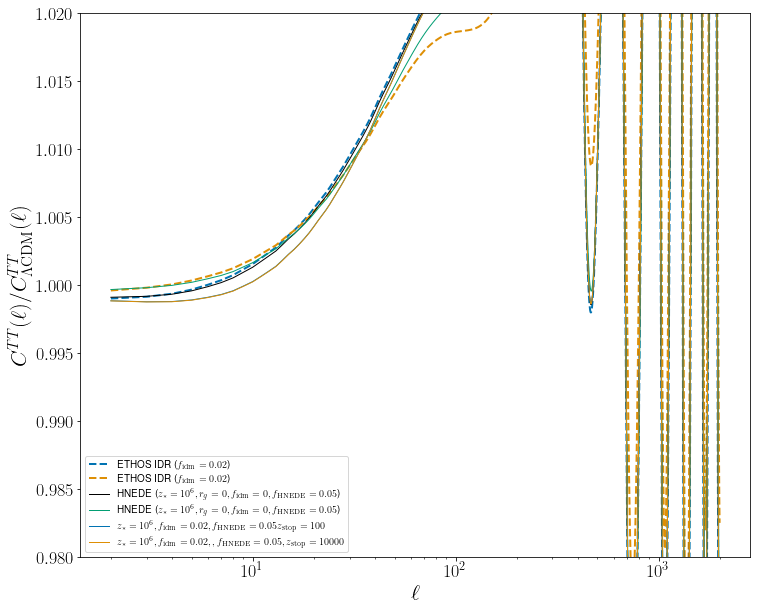

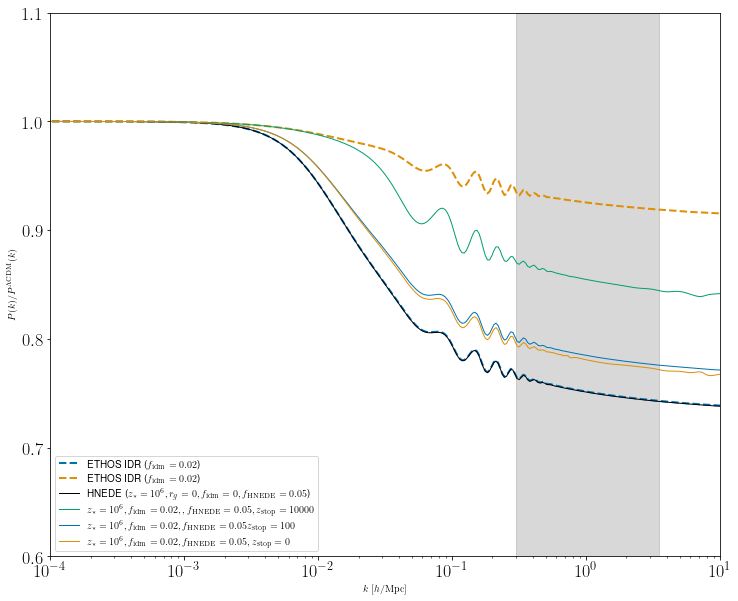

In [77]:
def get_cls_pk(cosmoM):

  cls_total = []
  cls = cosmoM.lensed_cl(2000)
  cls_total.append(cls["tt"])
  ell_array = cls["ell"]
  
  kk = np.logspace(-5,np.log10(20),400)
  h_factor = cosmoM.h()
  pks = []
  for jj in range(len(kk)):
    pks.append(cosmoM.pk_lin(kk[jj]*h_factor,0)*h_factor**3.)

  return ell_array, ell_array*(ell_array+1)*1e9*cls["tt"], kk, np.array(pks)

LCDM_base_H0_ell_array, LCDM_base_H0_Cells, LCDM_base_H0_kk, LCDM_base_H0_pks = get_cls_pk(LCDM_base_H0)
ETHOS_ell_array, ETHOS_Cells, ETHOS_kk, ETHOS_pks = get_cls_pk(ETHOS)
ETHOS2_ell_array, ETHOS2_Cells, ETHOS2_kk, ETHOS2_pks = get_cls_pk(ETHOS2)
NEDE_base_H0_ell_array, NEDE_base_H0_Cells, NEDE_base_H0_kk, NEDE_base_H0_pks = get_cls_pk(NEDE_base_H0)
NEDE_base_H0_2_ell_array, NEDE_base_H0_2_Cells, NEDE_base_H0_2_kk, NEDE_base_H0_2_pks = get_cls_pk(NEDE_base_H0_2)
NEDE_base_H0_3_ell_array, NEDE_base_H0_3_Cells, NEDE_base_H0_3_kk, NEDE_base_H0_3_pks = get_cls_pk(NEDE_base_H0_3)
NEDE_base_H0_4_ell_array, NEDE_base_H0_4_Cells, NEDE_base_H0_4_kk, NEDE_base_H0_4_pks = get_cls_pk(NEDE_base_H0_4)
#IDM_base_H0_ell_array, IDM_base_H0_Cells, IDM_base_H0_kk, IDM_base_H0_pks = get_cls_pk(IDM_base_H0)

#ccolor = ['#377eb8','black', '#ff7f00', '#ff7f00', '#4daf4a', '#4daf4a']
ccolor = ['orange', 'black', '#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494']
llabel = [r'ETHOS IDR ($f_{\rm idm} = 0.02$)',r'ETHOS IDR ($f_{\rm idm} = 0.02$)', r'HNEDE ($z_\ast = 10^{6}, r_g = 0,f_{\rm idm} = 0,f_{\rm HNEDE} = 0.05 $)', r'$z_\ast = 10^{6},f_{\rm idm} = 0.02,f_{\rm HNEDE} = 0.05,z_\mathrm{stop}=0$  ', r'$z_\ast = 10^{6},f_{\rm idm} = 0.02,f_{\rm HNEDE} = 0.05z_\mathrm{stop}=100$', r'$z_\ast = 10^{6},f_{\rm idm} = 0.02,,f_{\rm HNEDE} = 0.05,z_\mathrm{stop}=10000$', r'$z_\ast = 10^{6}$', r'+$z_\ast = 10^{6},z_\mathrm{stop}=10000$']
llinestyle = ['--', '-', '-','-', '-', '-']
llinewidth = 2


plt.rcParams['figure.figsize'] = [12, 10]
plt.clf()

plt.xscale('log')
#plt.xlim(.0001,10)

#plt.plot(LCDM_base_H0_ell_array, IDM_base_H0_Cells/LCDM_base_H0_Cells, label = llabel[0], linestyle = llinestyle[0], color = ccolor[0], linewidth = llinewidth)
plt.plot(NEDE_base_H0_ell_array, ETHOS_Cells/LCDM_base_H0_Cells, label = llabel[0], linestyle = llinestyle[0], color = ccolor[2], linewidth = llinewidth)
plt.plot(NEDE_base_H0_ell_array, ETHOS2_Cells/LCDM_base_H0_Cells, label = llabel[1], linestyle = llinestyle[0], color = ccolor[3], linewidth = llinewidth)
plt.plot(NEDE_base_H0_ell_array, NEDE_base_H0_Cells/LCDM_base_H0_Cells, label = llabel[2], linestyle = llinestyle[1], color = ccolor[1], linewidth = llinewidth-1)
plt.plot(NEDE_base_H0_ell_array, NEDE_base_H0_2_Cells/LCDM_base_H0_Cells, label = llabel[2], linestyle = llinestyle[3], color = ccolor[4], linewidth = llinewidth-1)
plt.plot(NEDE_base_H0_ell_array, NEDE_base_H0_3_Cells/LCDM_base_H0_Cells, label = llabel[4], linestyle = llinestyle[3], color = ccolor[2], linewidth = llinewidth-1)
plt.plot(NEDE_base_H0_ell_array, NEDE_base_H0_4_Cells/LCDM_base_H0_Cells, label = llabel[5], linestyle = llinestyle[3], color = ccolor[3], linewidth = llinewidth-1)


#plt.axvspan(40, 1900, color='gray', alpha=0.3)

plt.xlabel(r"$\ell$ ", fontsize = 22)
plt.ylabel(r"$C^{TT}(\ell)/C^{TT}_{\Lambda \rm CDM}(\ell)$", fontsize = 22)
plt.legend(loc=3, fontsize = 10)
plt.ylim(.98,1.02)

#savename = "./plots/cl_S8_ratio_newzratio_z5"
#print(savename)
#plt.savefig(savename+'.png', format='png', bbox_inches='tight')
#plt.savefig(savename+'.pdf', format='pdf', bbox_inches='tight')
plt.show()

plt.clf()
plt.xscale('log')
plt.xlim(.0001,10)

#plt.plot(NEDE_base_H0_kk, IDM_base_H0_pks/LCDM_base_H0_pks, label = llabel[0], linestyle = llinestyle[0], color = ccolor[0], linewidth = llinewidth)
plt.plot(ETHOS_kk, ETHOS_pks/LCDM_base_H0_pks, label = llabel[0], linestyle = llinestyle[0], color = ccolor[2], linewidth = llinewidth)
plt.plot(ETHOS2_kk, ETHOS2_pks/LCDM_base_H0_pks, label = llabel[1], linestyle = llinestyle[0], color = ccolor[3], linewidth = llinewidth)
plt.plot(NEDE_base_H0_kk, NEDE_base_H0_pks/LCDM_base_H0_pks, label = llabel[2], linestyle = llinestyle[1], color = ccolor[1], linewidth = llinewidth-1)
plt.plot(NEDE_base_H0_kk, NEDE_base_H0_2_pks/LCDM_base_H0_pks, label = llabel[5], linestyle = llinestyle[3], color = ccolor[4], linewidth = llinewidth-1)
plt.plot(NEDE_base_H0_kk, NEDE_base_H0_3_pks/LCDM_base_H0_pks, label = llabel[4], linestyle = llinestyle[3], color = ccolor[2], linewidth = llinewidth-1)
plt.plot(NEDE_base_H0_kk, NEDE_base_H0_4_pks/LCDM_base_H0_pks, label = llabel[3], linestyle = llinestyle[3], color = ccolor[3], linewidth = llinewidth-1)


plt.xlabel(r"$k$ $[h/{\rm Mpc}]$", fontsize = 10)
plt.ylabel(r"$P(k)/P^{\Lambda \rm CDM}(k)$", fontsize = 10)
plt.axvspan(0.3, 3.5, color='gray', alpha=0.3)
plt.ylim(.6,1.1)
plt.legend(loc=3, fontsize = 10)

#savename = "./plots/pk_S8_ratio_newzratio_z5"
#print(savename)
##plt.savefig(savename+'.png', format='png', bbox_inches='tight')
#plt.savefig(savename+'.pdf', format='pdf', bbox_inches='tight')
plt.show()

plt.close('all')


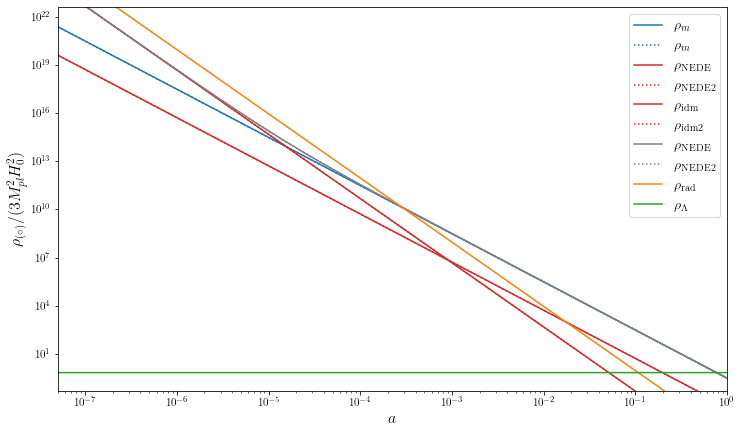

In [73]:
s=14
fs=16 #fontsize

color_sequence = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']



NEDE_derived=NEDE_base_H0_4.get_current_derived_parameters(['z_rec','H0','sigma8'])
NEDE_bg = NEDE_base_H0_4.get_background()
NEDE2_bg = NEDE_base_H0.get_background()
ETHOS_bg = ETHOS2.get_background()
#NEDE_Dstar=NEDE_base_H0_4.angular_distance(NEDE_z_rec)*(NEDE_z_rec+1)
NEDE_pert = NEDE_base_H0_4.get_perturbations()
NEDE_pert2 = NEDE_base_H0.get_perturbations()



NEDE_z_rec=NEDE_derived['sigma8']


NEDE_a_rec=1/(NEDE_z_rec+1)





#print(EDE.Hubble(EDE_z_decay) * EDE_a_decay)
#print(EDE.Hubble(EDE_z_rec) * EDE_a_rec)
#print(EDE_a_decay)

#EDE.Neff()


#print("Neff EDE: " + str(EDE.Neff()))
#print("Neff DR: " + str(DR.Neff()))
#print("Neff LCDM: " + str(LCDM.Neff()))

a_NEDE=1/(NEDE_bg['z']+1)
H_NEDE=NEDE_bg['H [1/Mpc]']
H0_NEDE=H_NEDE[-1]

a_NEDE2=1/(NEDE2_bg['z']+1)
H_NEDE2=NEDE2_bg['H [1/Mpc]']
H0_NEDE2=H_NEDE2[-1]

a_NEDE3=1/(ETHOS_bg['z']+1)
H_NEDE3=ETHOS_bg['H [1/Mpc]']
H0_NEDE3=H_NEDE3[-1]






rho_rad=np.zeros(a_NEDE.size)
rho_EDE=NEDE_bg['(.)rho_idr_drmd']
rho_EDE2=NEDE2_bg['(.)rho_idr_drmd']



rho_matter=(NEDE_bg['(.)rho_cdm']+NEDE_bg['(.)rho_b']+NEDE_bg['(.)rho_idm_drmd'])
rho_matter2=(NEDE2_bg['(.)rho_cdm']+NEDE2_bg['(.)rho_b'])

rho_idm=(NEDE_bg['(.)rho_idm_drmd'])
rho_idm2=(NEDE2_bg['(.)rho_idm_drmd'])


#rho_rad[decay_pos:]=rho_EDE[decay_pos:]
rho_rad=rho_rad+NEDE_bg['(.)rho_g']+NEDE_bg['(.)rho_ur']


plt.rcParams['figure.figsize'] = [12, 24]
ax1 = plt.subplot(311)
plt.loglog(a_NEDE, rho_matter/H0_NEDE**2,label=r'$\rho_m$',c=color_sequence[0])
plt.loglog(a_NEDE2, rho_matter2/H0_NEDE2**2,label=r'$\rho_m$',c=color_sequence[0],ls=':')
plt.loglog(a_NEDE, rho_EDE/H0_NEDE**2,label=r'$\rho_{\rm NEDE}$',c=color_sequence[3]) 
plt.loglog(a_NEDE2, rho_EDE2/H0_NEDE2**2,label=r'$\rho_{\rm NEDE2}$',c=color_sequence[3],ls=':')  
  

plt.loglog(a_NEDE, rho_idm/H0_NEDE**2,label=r'$\rho_{\rm idm}$',c=color_sequence[3]) 
plt.loglog(a_NEDE2, rho_idm2/H0_NEDE2**2,label=r'$\rho_{\rm idm2}$',c=color_sequence[3],ls=':')   
 

plt.loglog(a_NEDE, (rho_matter+rho_EDE)/H0_NEDE**2,label=r'$\rho_{\rm NEDE}$',c=color_sequence[7]) 
plt.loglog(a_NEDE2, (rho_matter2+rho_EDE2)/H0_NEDE2**2,label=r'$\rho_{\rm NEDE2}$',c=color_sequence[7],ls=':')  
plt.loglog(a_NEDE, rho_rad/H0_NEDE**2,label=r'$\rho_{\rm rad}$',c=color_sequence[1])
#plt.loglog(a_NEDE, NEDE_bg['(.)rho_trigger']/H0_NEDE**2,label=r'$\rho_{\phi}$',c=color_sequence[4])
#plt.loglog(a_NEDE2, NEDE2_bg['(.)rho_trigger']/H0_NEDE**2,ls=':',c=color_sequence[4])
plt.loglog(a_NEDE, NEDE_bg['(.)rho_lambda']/H0_NEDE**2,label=r'$\rho_{\Lambda}$',c=color_sequence[2])
#plt.loglog(a_EDE2, EDE2_bg['(.)rho_lambda']/H0_EDE2**2,ls=':',c=color_sequence[2])

plt.xlim((0.00000005,1))


plt.ylim((0.05,0.4e23))


plt.xlabel(r'$a$',fontsize=fs)
ax1.set_ylabel(r'$\rho_{(\circ)} / (3M_{pl}^2 H_0^2)$', fontsize=fs)
plt.legend(fontsize=14)
plt.setp(ax1.get_xticklabels(), fontsize=11)
plt.setp(ax1.get_yticklabels(), fontsize=11)
plt.savefig('fld_bg.pdf',bbox_inches='tight')
plt.show()
plt.close('all')





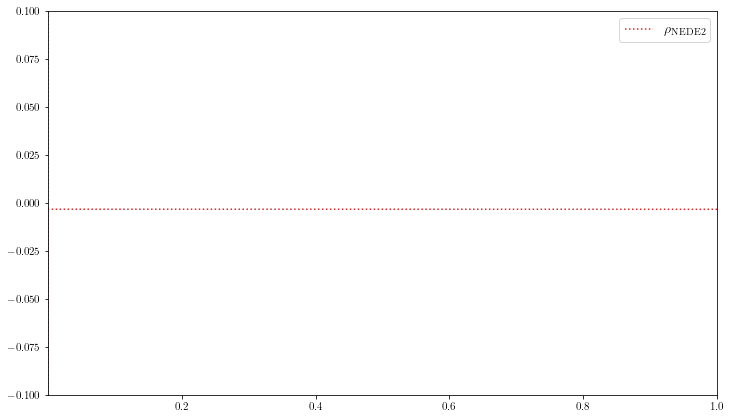

In [6]:
diff=(np.interp(a_NEDE3,a_NEDE,rho_EDE2)-rho_DR)/np.interp(a_NEDE3,a_NEDE,rho_EDE2)

plt.rcParams['figure.figsize'] = [12, 24]
ax1 = plt.subplot(311)
plt.plot(a_NEDE3, diff,label=r'$\rho_{\rm NEDE2}$',c=color_sequence[3],ls=':')  


plt.axvline(x=NEDE_a_decay,ls=':',c='gray')
plt.xlim((0.00000005,1))


plt.ylim((-0.1,0.1))


plt.legend(fontsize=14)
plt.setp(ax1.get_xticklabels(), fontsize=11)
plt.setp(ax1.get_yticklabels(), fontsize=11)
plt.show()
plt.close('all')

<Figure size 2160x3600 with 0 Axes>

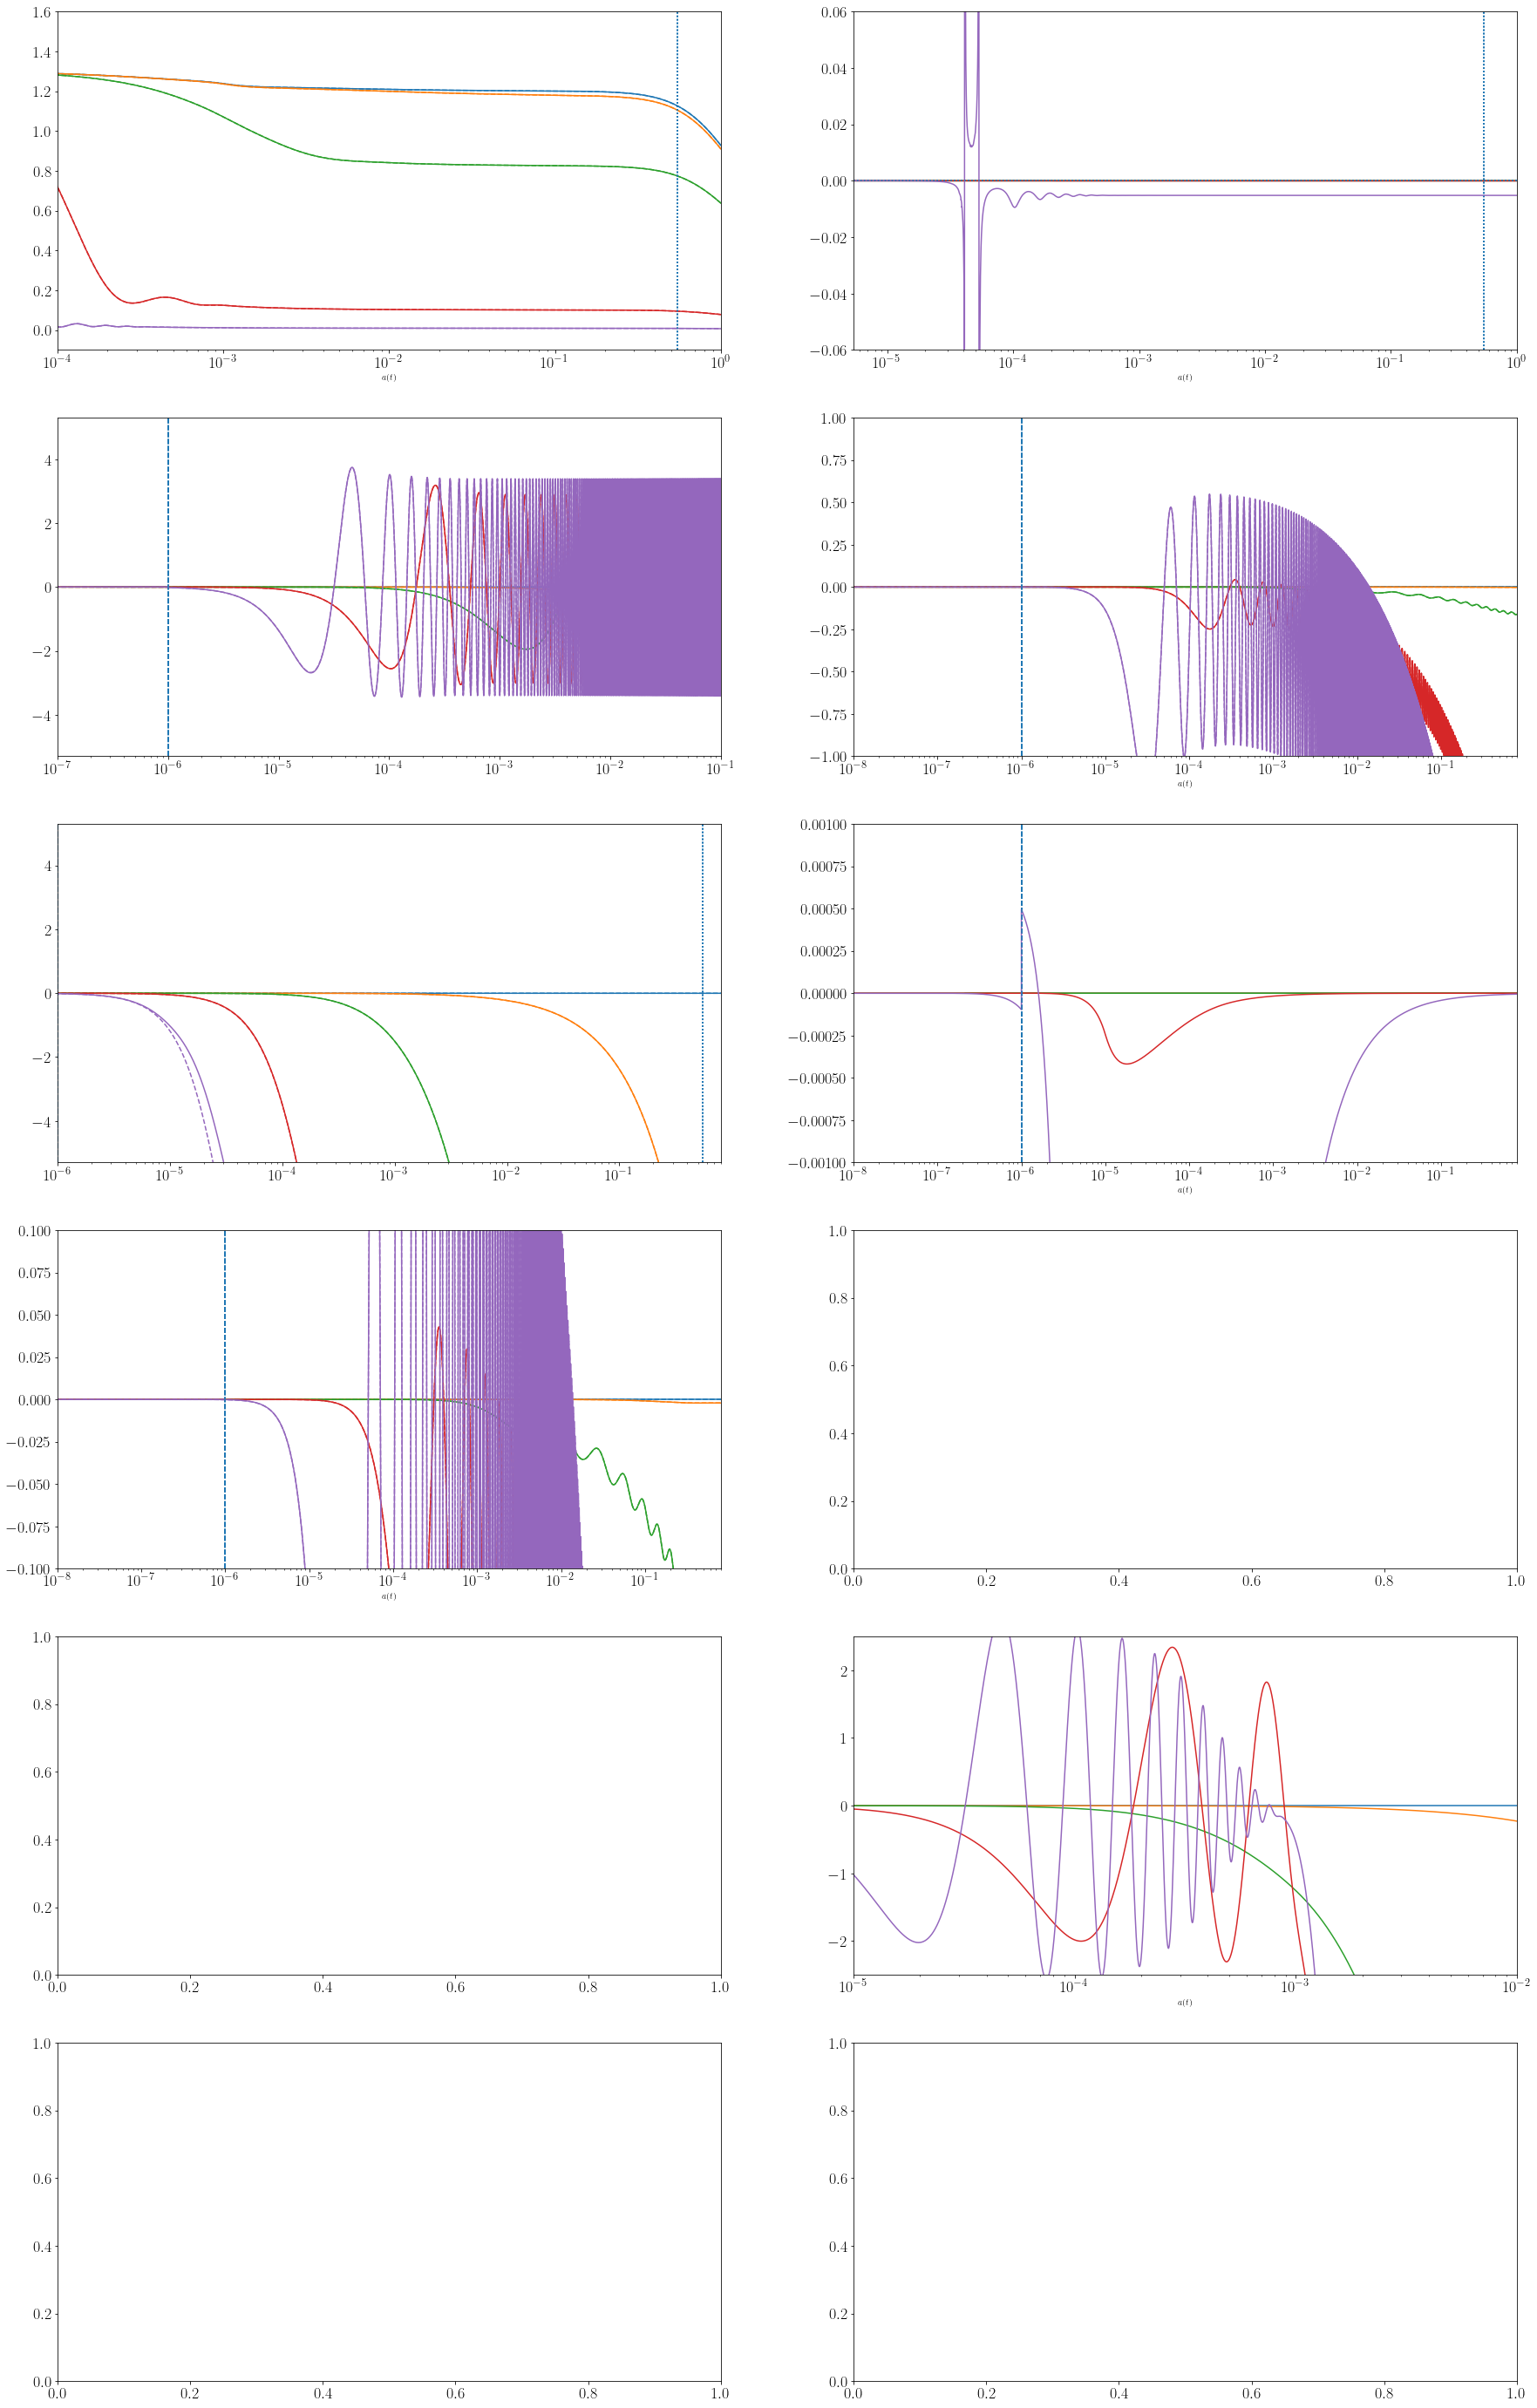

In [7]:




NEDE_sarray = NEDE_pert['scalar']
NEDE2_sarray = NEDE_pert2['scalar']
#LCDM_sarray = LCDM_pert['scalar']

plt.rcParams['figure.figsize'] = [30, 50]
plt.subplots_adjust(hspace=0.1)

fig, ((ax1, ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8),(ax9,ax10),(ax11,ax12)) = plt.subplots(6, 2)
#fig, ((ax1, ax2)) = plt.subplots(1, 2)

for i in range(5):
    NEDE_sdict = NEDE_sarray[i]
    NEDE_a = NEDE_sdict['a']
    NEDE2_sdict = NEDE2_sarray[i]
    NEDE2_a = NEDE2_sdict['a']
    
    #LCDM_sdict = LCDM_sarray[i]
    #LCDM_a = LCDM_sdict['a']
    

    NEDE_perturb = NEDE_sdict['psi']+NEDE_sdict['phi']
    NEDE2_perturb = NEDE2_sdict['psi']+NEDE2_sdict['phi']
    ax1.semilogx(NEDE_a,NEDE_perturb,color=color_sequence[i])
    ax1.semilogx(NEDE2_a,NEDE2_perturb,color=color_sequence[i],ls='--')
    ax1.axvline(x=NEDE_a_decay,ls='--',color=color_sequence[i])
    ax1.axvline(x=NEDE_a_rec,ls=':')
    ax1.set_xlim((0.00010,1))
    #ax1.set_xlim((0.000075,0.0008))
    ax1.set_xlabel(r"$a(t)$")
    ax1.set_ylim((-0.1,1.6))
    #ax1.set_ylim((1.2,1.29))


    diff_Weyl=(np.interp(NEDE2_a,NEDE_a,NEDE_perturb)-NEDE2_perturb)/np.interp(NEDE2_a,NEDE_a,NEDE_perturb)
    
    ax2.semilogx(NEDE2_a,diff_Weyl)
    ax2.axvline(x=NEDE_a_decay,ls='--',color=color_sequence[i])
    ax2.axvline(x=NEDE_a_rec,ls=':')
    ax2.axhline(y=0,ls=':')
    ax2.set_xlim((0.0000054,1))
    ax2.set_xlabel(r"$a(t)$")
    ax2.set_ylim((-0.06,0.06))

    
    NEDE_perturb = NEDE_sdict['delta_NEDE']
    NEDE2_perturb = NEDE2_sdict['delta_NEDE']
    ax3.semilogx(NEDE_a,NEDE_perturb,color=color_sequence[i])
    ax3.semilogx(NEDE2_a,NEDE2_perturb,color=color_sequence[i],ls='--')
    ax3.axvline(x=1/(NEDE_z_decay+1),ls='--')
    ax3.axvline(x=NEDE_a_rec,ls=':')
    ax3.set_xlim((0.0000001,0.1))
    ax3.set_ylim((-5.3,5.3))


    NEDE_perturb = NEDE_sdict['delta_idm_HNEDE']
    NEDE2_perturb = NEDE2_sdict['delta_cdm']
    ax5.semilogx(NEDE_a,NEDE_perturb,color=color_sequence[i])
    ax5.semilogx(NEDE2_a,NEDE2_perturb,color=color_sequence[i],ls='--')
    ax5.axvline(x=1/(NEDE_z_decay+1),ls='--')
    ax5.axvline(x=NEDE_a_rec,ls=':')
    ax5.set_xlim((0.000001,0.8))
    ax5.set_ylim((-5.3,5.3))
    
    #ax3.set_xlim((0.00075,0.0008))
    #ax3.set_xlabel(r"$a(t)$")
    #ax3.set_ylim((-15,15))
    #ax3.set_ylim((-.03,.03))
    #plt.rcParams['figure.figsize'] = [20, 10]
    
    #diff_NEDE_delta=(-np.interp(EDE_a,EDE2_a,EDE2_perturb)+EDE_perturb)
    
    #EDE_perturb = EDE_sdict['theta_NEDE']
    #ax4.semilogx(EDE_a,EDE_perturb,color=color_sequence[i])
    #ax4.semilogx(EDE_a,diff_NEDE_delta,color=color_sequence[i])
    #ax4.axvline(x=1/(EDE_z_decay+1),ls='--')
    #ax4.axvline(x=EDE_a_rec,ls=':')
    #ax4.set_xlim((0.0001,0.1))
    #ax4.set_xlim((0.00010,0.1))
    #ax4.set_xlabel(r"$a(t)$")
    #ax4.set_ylim((-1,.1))
    #ax4.set_ylim((-.000002,.000002))
    #plt.rcParams['figure.figsize'] = [20, 10]
    

    NEDE_perturb = NEDE_sdict['theta_NEDE']
    NEDE2_perturb = NEDE2_sdict['theta_NEDE']
    ax4.semilogx(NEDE_a,NEDE_perturb,color=color_sequence[i])
    ax4.semilogx(NEDE2_a,NEDE2_perturb,color=color_sequence[i],ls='--')
    ax4.axvline(x=1/(NEDE_z_decay+1),ls='--')

    ax4.set_xlim((0.00000001,0.8))
    ax4.set_xlabel(r"$a(t)$")
    ax4.set_ylim((-1,1))

    NEDE_perturb = NEDE_sdict['theta_idm_HNEDE']
    #NEDE2_perturb = NEDE2_sdict['theta_idm_HNEDE']
    ax6.semilogx(NEDE_a,NEDE_perturb,color=color_sequence[i])
    #ax6.semilogx(NEDE2_a,NEDE2_perturb,color=color_sequence[i],ls='--')
    ax6.axvline(x=1/(NEDE_z_decay+1),ls='--')

    ax6.set_xlim((0.00000001,0.8))
    ax6.set_xlabel(r"$a(t)$")
    ax6.set_ylim((-0.001,0.001))
    
    #EDE_perturb=(-np.interp(EDE_a,EDE2_a,EDE2_perturb)+EDE_perturb)
    #EDE_perturb = EDE_sdict['theta_g']
    #ax6.semilogx(EDE_a,EDE_perturb,color=color_sequence[i])
    #ax6.axvline(x=1/(EDE_z_decay+1),ls='--')
    #ax6.set_xlim((0.0001,0.1))
    #ax6.set_xlim((0.00075,0.0008))
    #ax6.set_xlabel(r"$a(t)$")
    #ax6.set_ylim((-.0000005,.0000005))

 
    NEDE_perturb = NEDE_sdict['theta_idr']
    NEDE2_perturb = NEDE2_sdict['theta_idr']
    ax7.semilogx(NEDE_a,NEDE_perturb,color=color_sequence[i])
    ax7.semilogx(NEDE2_a,NEDE2_perturb,color=color_sequence[i],ls='--')
    ax7.axvline(x=1/(NEDE_z_decay+1),ls='--')

    ax7.set_xlim((0.00000001,0.8))
    ax7.set_xlabel(r"$a(t)$")
    ax7.set_ylim((-0.1,0.1))



    
    EDE_perturb = NEDE_sdict['delta_b']
    ax10.semilogx(NEDE_a,EDE_perturb,color=color_sequence[i])
    ax10.axvline(x=1/(NEDE_z_decay+1),ls='--')
    ax10.set_xlabel(r"$a(t)$")
    ax10.set_ylim((-2.5,2.5))
    ax10.set_xlim((0.00001,0.01))


    
    #EDE_perturb = EDE_sdict['phi']
    #EDE_perturb = EDE_sdict['theta_NEDE']
    #EDE2_perturb = EDE2_sdict['theta_NEDE']
    #ax11.semilogx(EDE_a,EDE_perturb,color=color_sequence[i])
    #ax11.axvline(x=1/(EDE_z_decay+1),ls='--')
    #ax11.set_xlim((0.0001,0.1))
    #ax11.set_xlim((0.00075,0.0008))
    #ax11.set_xlabel(r"$a(t)$")
    #ax11.set_ylim((-2.5,2.5))
    #ax11.set_ylim((.64,.646))
    
    #EDE_perturb = EDE_sdict['psi']
    #LCDM_perturb = LCDM_sdict['psi']
    #EDE_perturb=(-np.interp(EDE_a,EDE2_a,EDE2_perturb)+EDE_perturb)
    #ax12.semilogx(EDE_a,EDE_perturb,color=color_sequence[i])
    #ax12.semilogx(LCDM_a,LCDM_perturb,color=color_sequence[i])
    #ax12.axvline(x=1/(EDE_z_decay+1),ls='--')
    #ax12.set_xlim((0.0001,0.001))
    #ax12.set_xlim((0.00075,0.0008))
    #ax12.set_xlabel(r"$a(t)$")
    #ax12.set_ylim((-.000006,.0000061))

plt.show()
plt.close('all')